<h1>1. Загрузка данных</h1>

Необходимо извлечь изображения из Gauge.zip и сохранить в директорию images с поддиректориями train, test, valid, каждая из которых содержит каталоги по классу изображения

Извлечем данные из Gauge.zip

In [1]:
import zipfile
import os

zip_file_path = 'Gauge.zip'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()

print(f'Архив извлечен')

Архив извлечен


Проверим существование директории Gauge_big, куда были извлечены файлы

In [2]:
if os.path.isdir('Gauge_big'):
    print('Директория существует.')
else:
    print('Директория не существует')

Директория существует.


Далее надо переименовать корневую папку Gauge_big в images

In [3]:
old_folder_name = 'Gauge_big'
new_folder_name = 'images'

os.rename(old_folder_name, new_folder_name)
print('Папка перименована')

Папка перименована


Так же надо переименовать папку images/val в images/valid

In [4]:
old_folder_name = 'images/val'
new_folder_name = 'images/valid'

os.rename(old_folder_name, new_folder_name)
print('Папка перименована')

Папка перименована


<h1>2. Предварительная обработка</h1>

Напишем функцию, которая откроет входное изображение, переведет его к размеру 224х224,<br> переведет в серый цвет и сохранит в папку preprocessed_images с теми же поддиректориями

In [5]:
import cv2
def prerprocess(pic):
    #загрузка изображения
    image = cv2.imread(pic)
    #преобразование к формату 224х224х3
    resized_image = cv2.resize(image, (224, 224))
    #преобразование в оттенки серого
    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    # Создаем папку, если она не существует
    folder_path = os.path.dirname(pic)
    fin_path = 'preprocessed_images/'+folder_path.removeprefix('images/')
    os.makedirs(fin_path, exist_ok=True)
    #сохранение в директорию preprocessed_images
    cv2.imwrite('preprocessed_images/'+pic.removeprefix('images/'), gray_image)
    

<h1>3. Применение функции предобработки ко всем изображениям</h1>

Далее нам нужно обработать файлы в папках<br>
Для этого напишем функцию, которая соберет пути ко всем нашим изображениям в один лист

In [6]:
#получение списка всех изображений(путей)
def list_files(directory):
    all_items = []
    for root, dirs, files in os.walk(directory):
        for name in files:
            all_items.append(os.path.join(root, name))  # Добавляем файлы
    return all_items

directory_path = 'images'
items = list_files(directory_path)

Применим созданную во втором пункте функцию prerprocess к листу со всеми путями изображений

In [7]:
# выполенение функции prerprocess для всех элементов
for pic in items:
    prerprocess(pic)
print('Обработка завершена')

Обработка завершена


<h1>4. Расширение датасета </h1>

Далее напишем функцию которая получит на вход путь к файлу, откроет его и создаст две копии файла: <br> одна с квадратом из черных пикселей (размер от 20 до 50 пикселей),<br> вторая с поворотом изображения от 15 до - 15 градусов

In [8]:
import matplotlib.pyplot as plt
import random
def augment(pic, show_results = False):
    #открытие изображения
    img = cv2.imread(pic,cv2.IMREAD_GRAYSCALE)
    corrupted_img = img.copy()
    #поворот изображения _tilted
    h, w = img.shape
    angle = random.randint(-15,15)  # Угол поворота в градусах
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0) 
    tilted_img = cv2.warpAffine(img, M, (w, h))
    #вырезание пикселей в случайной области(от 20х20 до 50х50) _corrupted
    square_size = random.randint(20,50) #размер квадрата
    x = random.randint(0, w - square_size)
    y = random.randint(0, h - square_size)
    corrupted_img[y:y + square_size, x:x + square_size] = 0
    
    if(show_results): # отображение графиков
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(img,cmap='gray')
        axs[0].axis('off')
        axs[0].set_title('Original')
        axs[1].imshow(tilted_img,cmap='gray')
        axs[1].axis('off')
        axs[1].set_title('Tilted')
        axs[2].imshow(corrupted_img,cmap='gray')
        axs[2].axis('off')
        axs[2].set_title('Corrupted')
        plt.tight_layout()
        plt.show()
    else: #сохранение изображений
        file_path_tilt = pic.removesuffix('.jpg') + '_tilted.jpg'
        file_path_corr = pic.removesuffix('.jpg') + '_corrupted.jpg'
        #проверка на существование файлов
        if os.path.isfile(file_path_tilt) and os.path.isfile(file_path_corr):
            print("Файлы существуют.")
        else:
            cv2.imwrite(pic.removesuffix('.jpg') + '_tilted.jpg', tilted_img)
            cv2.imwrite(pic.removesuffix('.jpg') + '_corrupted.jpg', corrupted_img)

        

<h1>5. Выполнение аугментаций</h1>

Собираем первые файлы в каждой папке 

In [9]:
def list_file(directory):
    all_items = []
    for root, dirs, files in os.walk(directory):
        if(len(files)>0):
            all_items.append(os.path.join(root, files[0]))  # Добавляем файл    
    return all_items

directory_path = 'preprocessed_images/train'
items_prep = list_file(directory_path)

Кол-во файлов до выполнения функции

In [10]:
len(list_files('preprocessed_images/train'))

21000

Выполняем функцию аугментации ко всем файлам

In [11]:
for item in items_prep:
    augment(item)
print('Аугментация завершена')

Аугментация завершена


In [12]:
len(list_files('preprocessed_images/train'))

23000

Посмотрим на варианты первого изображения

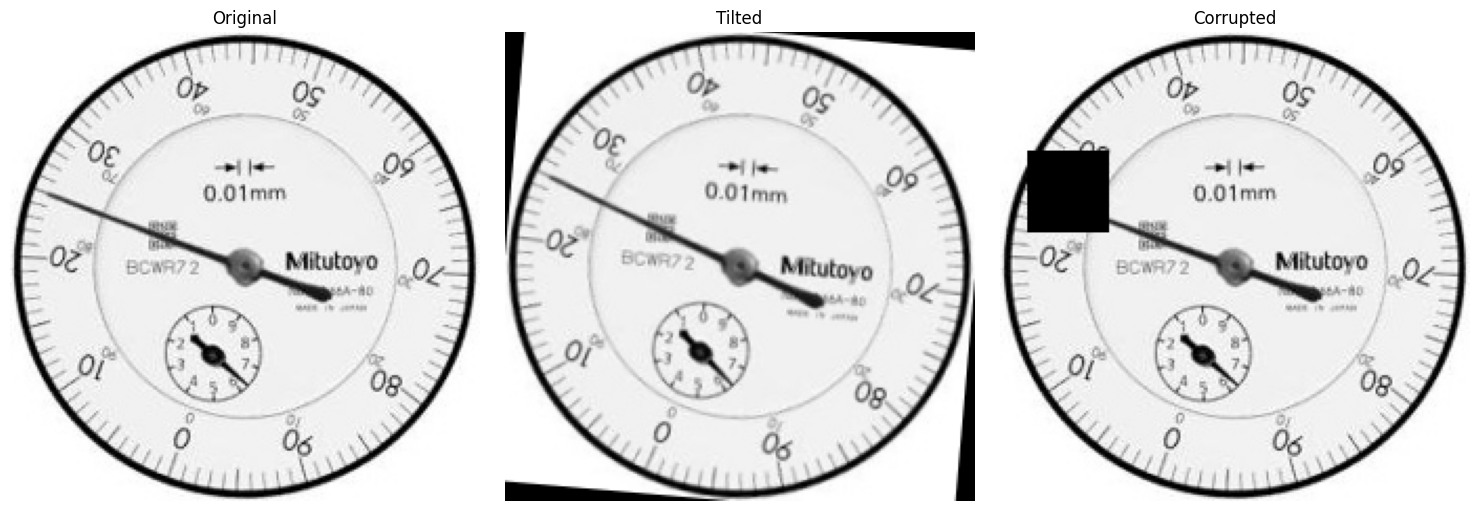

In [13]:
augment(items_prep[0],True)

И на варианты 525 изображения

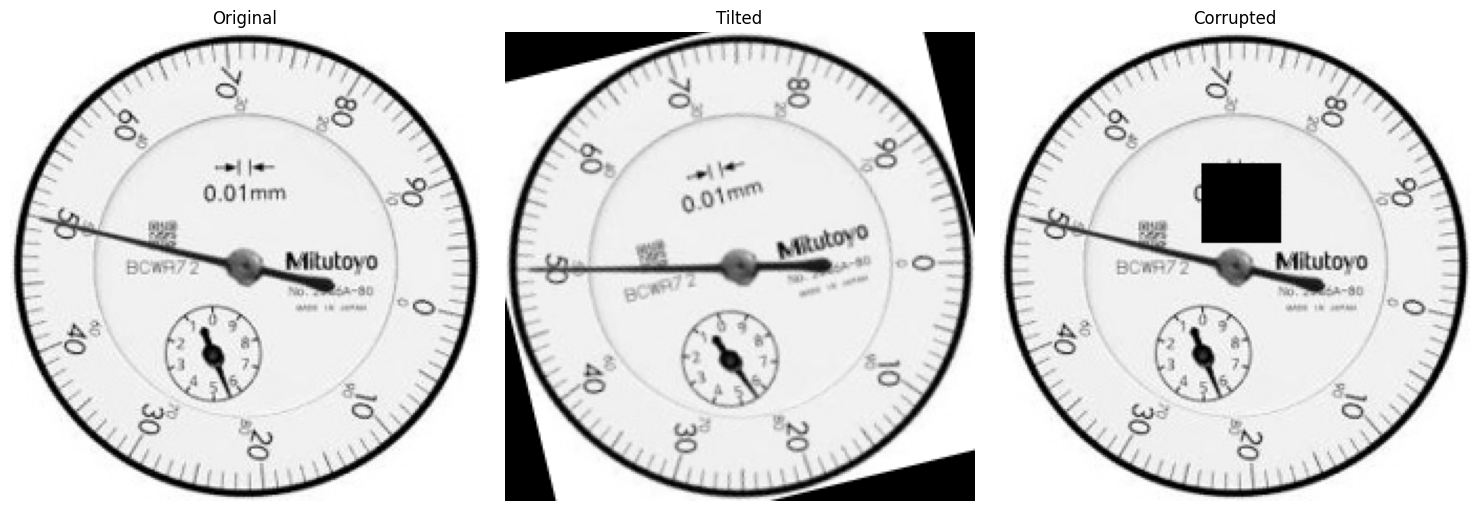

In [14]:
augment(items_prep[524],True)

Так же попробуем перезаписать первое изображение

In [15]:
augment(items_prep[0])

Файлы существуют.


<h1>6.  Формирование итогового датасета</h1>

Сначала проверим, что у нас данные соответствуют требованиям<br>
23000 изображений для обучающей выборки, 1000 для тестовой и 2000 для валидационной

Посмотрим количество файлов в валидационной выборке

In [16]:
len(list_files('preprocessed_images/train'))

23000

Соответствует требованиям в 23000 файлов

Посмотрим количество файлов в тестовой выборке

In [17]:
len(list_files('preprocessed_images/test'))

1000

Соответствует требованиям в 1000 файлов

Посмотрим количество файлов в валидационной выборке

In [18]:
len(list_files('preprocessed_images/valid'))

2000

Соответствует требованиям в 2000 файлов

Далее создадим zip архив с названием preprocessed_images.zip

In [19]:
def zipdir(path, ziph):
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file), 
                       os.path.relpath(os.path.join(root, file), 
                                       os.path.join(path, '..')))

with zipfile.ZipFile('preprocessed_images.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipdir('preprocessed_images', zipf)
    print('Архив создан')

Архив создан


Проверим существование архива

In [20]:
if os.path.isfile('preprocessed_images.zip'):
    print('Архив существует')
else:
    print('Архив не существует')

Архив существует


После выведем структурную схему датасета в виде дерева, где отобразим все папки и файлы

In [21]:
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print('{}{}'.format(subindent, f))

list_files('preprocessed_images')

preprocessed_images/
    valid/
        6-25/
            gauge_rotated_5_jpg.rf.9d989be9a5f5e3cdff954c21019fcf7d.jpg
            gauge_rotated_0_jpg.rf.fccc480137cf412e96e6e33622c0e7ba.jpg
        1-23/
            gauge_rotated_4_jpg.rf.c26e72297c77c4b778e8fbd8879c61c6.jpg
            gauge_rotated_0_jpg.rf.b790f98740e601b69964908f0f972c7e.jpg
        8-65/
            gauge_rotated_1_jpg.rf.9a6169951638f364774f00e90915adb2.jpg
            gauge_rotated_9_jpg.rf.8571468ccd60e850630ed5c2438476a0.jpg
        2-81/
            gauge_rotated_8_jpg.rf.a636cc9d217624d1155e165604f699d0.jpg
            gauge_rotated_7_jpg.rf.d0a52c3ad5a42f41f964ccef0463ff46.jpg
        4-83/
            gauge_rotated_3_jpg.rf.044e3ddb613ef7edee3b9bbcdf526fda.jpg
            gauge_rotated_6_jpg.rf.90d9f240ab94388e5ed54d76ded6b083.jpg
        1-62/
            gauge_rotated_3_jpg.rf.9806c3a49091b535f8c5883f88ec45bf.jpg
            gauge_rotated_6_jpg.rf.5345d65d6a124e262c36e2f815ce8263.jpg
        0-94/
      